In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from bgflow import IterativeSampler, SamplerStep, MCMCStep, SamplerState, GaussianProposal
import tqdm
from bgflow import LennardJonesPotential
from bgflow import  IterativeSampler, SamplerState, MCMCStep

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

In [5]:
n_particles = 13
spatial_dim = 3
dimensionality = spatial_dim * n_particles

In [49]:
import numpy as np
import glob

T = 2
noise_std = 0.2

samples = {}

for temp in [2]:
    # path_pattern = f"/network/scratch/a/alexander.tong/lj13_samples/samples_v7_{temp}*"
    path_pattern = f"/home/mila/t/tara.akhoundsadegh/scratch/lj13_samples/samples_{noise_std}_noise_{T}*"
    
    # Find all matching files
    files = sorted(glob.glob(path_pattern))

    arrays = [np.load(file) for file in files]
    s = np.concatenate(arrays, axis=0)

    print(f"Concatenated array shape: {s.shape}")
    # samples = torch.tensor(samples, dtype=torch.float32).to(device)
    s = s.reshape(-1, dimensionality)
    samples[temp] = s

# Set the prefix and axis for concatenation
# path_pattern = f"/home/mila/t/tara.akhoundsadegh/scratch/lj13_samples/samples_v4_{T}*"
# path_pattern = f"/home/mila/t/tara.akhoundsadegh/scratch/lj13_samples/samples_{noise_std}_noise_{T}*"
# path_pattern = f"/network/scratch/a/alexander.tong/lj13_samples/samples_v7_{T}*"

Concatenated array shape: (200000, 39)


In [17]:
from src.energies.lennardjones_energy import LennardJonesEnergy, lennard_jones_energy_torch
T = T.__float__()
target = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= "../../data/",
    smooth=False,
    temperature=T
    )


target_temp1 = LennardJonesEnergy(
    dimensionality=dimensionality,
    n_particles=n_particles,
    device=device,
    data_path= "../../data/",
    smooth=False,
    temperature=1.0
    )

In [34]:
target_temp1(a)

tensor([34.4879, 47.4321, 40.3685])

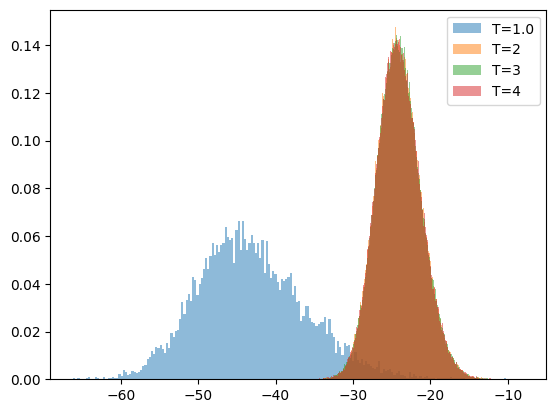

In [28]:
#plt.hist(-target(target.test_set).cpu().detach().numpy(), bins=200, alpha=0.5, density=True)
# 
plt.hist(-target_temp1(target_temp1.test_set).cpu().detach().numpy(), bins=200, alpha=0.5, density=True, label="T=1.0")
samples_energy = target(torch.tensor(samples[2], dtype=torch.float32).to(device)).cpu().detach().numpy()
plt.hist(-samples_energy, bins=300, density=True, alpha=0.5, label=f"T=2");

samples_energy = target(torch.tensor(samples[3], dtype=torch.float32).to(device)).cpu().detach().numpy()
plt.hist(-samples_energy, bins=300, density=True, alpha=0.5, label=f"T=3");


samples_energy = target(torch.tensor(samples[4], dtype=torch.float32).to(device)).cpu().detach().numpy()
plt.hist(-samples_energy, bins=300, density=True, alpha=0.5, label=f"T=4");

plt.legend()
plt.show()

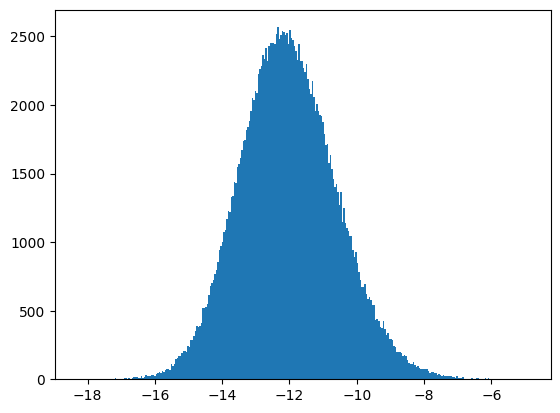

In [8]:
samples_energy = target(torch.tensor(samples, dtype=torch.float32).to(device)).cpu().detach().numpy()
plt.hist(-samples_energy, bins=300);
# plt.xlim(-80, 40)

In [8]:
samples_energy.mean()

np.float32(-6.2010493)

In [9]:
samples_energy.mean()

np.float32(-6.2010493)

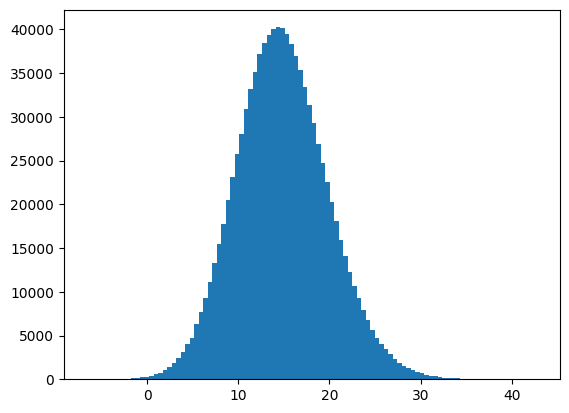

In [22]:
samples_energy = target(torch.tensor(samples, dtype=torch.float32).to(device)).cpu().detach().numpy()
plt.hist(-samples_energy, bins=100);


In [10]:
# randomly generate idices for train, val and test
idxs = np.random.permutation(samples.shape[0])
train_idx = idxs[:100000]
val_idx = idxs[100000:110000]
test_idx = idxs[110000:120000]

In [11]:
samples_train = samples[train_idx]
samples_val = samples[val_idx]
samples_test = samples[test_idx]

In [12]:
# if directory does not exist, create it
import os
if not os.path.exists(f"../../data/LJ13_temp_{T}"):
    os.makedirs(f"../../data/LJ13_temp_{T}")

np.save(f"../../data/LJ13_temp_{T}/train_split_LJ13-1000.npy", samples_train)
np.save(f"../../data/LJ13_temp_{T}/val_split_LJ13-1000.npy", samples_val)
np.save(f"../../data/LJ13_temp_{T}/test_split_LJ13-1000.npy", samples_test)

In [13]:
target(samples).mean()

target(samples).std()

tensor(4.5715, device='cuda:0')

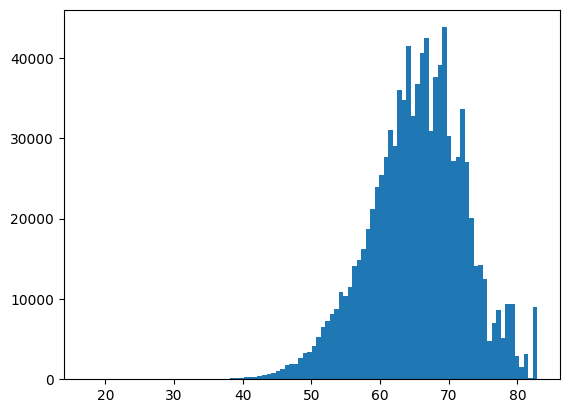

In [18]:
plt.hist(target(samples).detach().cpu().numpy(), bins=100);

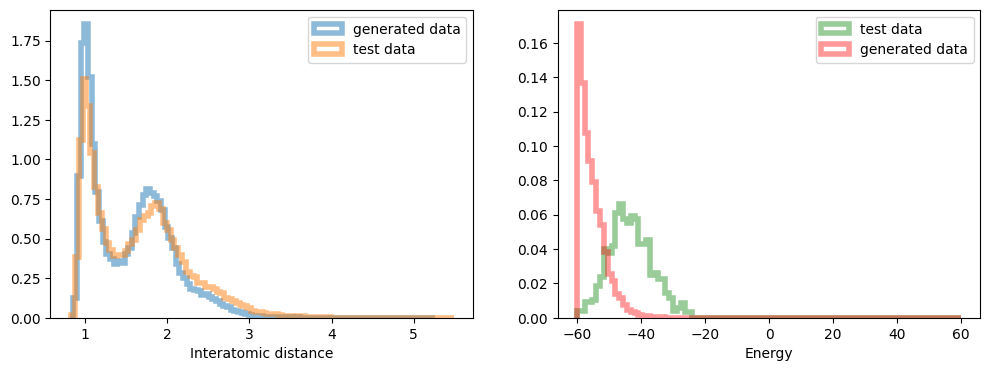

In [19]:
target.get_dataset_fig(samples, T=1.0, T_og=T);

In [48]:
from src.energies.lennardjones_energy import LennardJonesPotential

energy = LennardJonesPotential(dim=39, n_particles=13, two_event_dims=True)

n_samples = 1000
n_burnin = 1000

sampler_state = SamplerState(samples=[torch.randn(n_samples, 1, 13, 3)])
mcmc_step = MCMCStep(energy,
                     proposal=GaussianProposal(noise_std=0.05),
                     target_temperatures=3.0)
sampler = IterativeSampler(sampler_state,
                           sampler_steps=[mcmc_step],
                           stride=100,
                           n_burnin=n_burnin,
                           progress_bar=tqdm.tqdm,
                           return_hook=lambda samples: [samples[0][:,0]])

  0%|          | 0/1000 [00:00<?, ?it/s]

Accepance Ratio 0.4909999966621399
Accepance Ratio 0.3869999945163727
Accepance Ratio 0.3059999942779541
Accepance Ratio 0.26100000739097595
Accepance Ratio 0.2290000021457672
Accepance Ratio 0.18700000643730164
Accepance Ratio 0.1599999964237213
Accepance Ratio 0.1850000023841858
Accepance Ratio 0.17599999904632568
Accepance Ratio 0.1679999977350235
Accepance Ratio 0.15000000596046448


  0%|          | 0/1000 [00:45<?, ?it/s]


KeyboardInterrupt: 